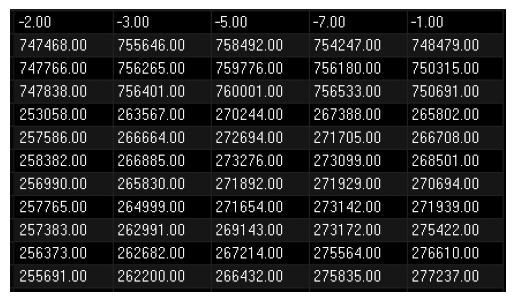

In [1]:
import cv2
import matplotlib.pyplot as plt

img1 = cv2.imread('data/2025-01-12/img_test.png', cv2.IMREAD_GRAYSCALE)

plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.show()

In [1]:
import os
import pyautogui
from PIL import Image
import tkinter as tk
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pytesseract
import pandas as pd
from matplotlib.collections import PolyCollection
import re
import tkinter.filedialog as fd
import math
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg, NavigationToolbar2Tk) 

In [ ]:
today = str(dt.datetime.now()).split(' ')[0]
try:
    os.mkdir(f'data/{today}')
except FileExistsError: # pass if the folder already exists
    pass
    
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
custom_config = r'--oem 3 --psm 6 outputbase digits'

imported = []
show_imported = []

def resizeFrame(event):
    if frame1 :
        frame1.place(x=40, rely=60/510, width=430, relheight=105/480)
        frame2.place(x=40, rely=1950/510, width=430, relheight=245/480)
        button1.place(relx=0.08, rely=0.01, relwidth=0.1, relheight=0.1)
        
def getTargetRegion(root, frame2):
    root_position = root.wm_geometry()
    x = int(root_position.split('+')[1])
    y = int(root_position.split('+')[2])
    # w = root.winfo_width()
    # h = root.winfo_height()
    frame_geo = frame2.winfo_geometry()
    x_f = int(frame_geo.split('+')[1])
    y_f = int(frame_geo.split('+')[2])
    w_f = frame2.winfo_width()
    h_f = frame2.winfo_height()
    return (x+x_f+8,y+y_f+31,w_f,h_f) # numbers 12 and 57 added to adjust a region of being captured

def readNumbers(img):
    # make an img larger to improve its accuracy
    (h, w) = img.shape[:2]
    new_width = 3000
    aspect_ratio = h / w
    new_height = int(new_width * aspect_ratio)
    img = cv2.resize(img, (new_width, new_height))
    # apply a threshold to increase accuracy
    _, binary = cv2.threshold(img, 80, 255, cv2.THRESH_BINARY_INV) # comprise more pixels than before (200,255)
    numbers = pytesseract.image_to_string(binary, config=custom_config)
    numbers_list = numbers.split('\n')
    temp = []
    while '' in numbers_list:
        numbers_list.remove('') # remove the element resulted fom \n
    for i in numbers_list:
        temp_elem = i.split('.00')
        while '' in temp_elem:
            temp_elem.remove('')
        temp.append(temp_elem)
    return temp

def countDigit(n):
    return math.floor(math.log10(n)+1)
    
def fillRows(temp):
    # rows = []
    # for idx, val in enumerate(numbers_list):
    #     rows.append(val.split('00'))
    # for idx, val in enumerate(rows):
    #     if len(val) != 6: # replaced with regex
    #         rows[idx] = re.findall(r'[-+]?\d+\.00', numbers_list[idx])
    #     while '' in val:
    #         val.remove('')
    #     rows[idx] = list(map(float, rows[idx]))
    # for i in range(len(rows)):
    #     for j in range(len(rows[i])):
    #         rows[i][j] = abs(rows[i][j])
    
    numbers_temp = []
    for row in temp:
        row_temp = []
        if len(row)!=5:
            for row_elem in row:
                if countDigit(int(row_elem)) <=6:
                    row_temp.append(row_elem)
                else:
                    row_temp.extend(row_elem.split('00', maxsplit=5-len(row)))
            numbers_temp.append(row_temp)
        else: 
            numbers_temp.append(row)
            
    for idx, row in enumerate(numbers_temp):
        numbers_temp[idx] = list(map(float, numbers_temp[idx]))
    
    return numbers_temp

def topNumbersToDf(numbers_list):
    rows = fillRows(numbers_list)
    df_top = pd.DataFrame(rows, columns=['W2','W1','C','E1','E2'])
    df_top['cm'] = [5+i for i in range(len(df_top))]
    df_top.set_index('cm', inplace=True)
    return df_top
    
def bottomNumbersToDf(numbers_list):
    rows = fillRows(numbers_list)
    df_bottom = pd.DataFrame(rows, columns=['E2','E1','C','W1','W2']) # inverse order
    df_bottom = df_bottom.iloc[::-1, ::-1] # reverse
    df_bottom['cm'] = [12+i for i in range(len(df_bottom))]
    df_bottom.set_index('cm', inplace=True)
    return df_bottom

def mergeDfs(dfs):
    return pd.concat([df for df in dfs])

def topPointNumbersToDf(numbers_list): # need to get position in cm
    rows = fillRows(numbers_list)
    df_top = pd.DataFrame(rows, columns=['W2','W1','C','E1','E2'])
    df_top = df_top.astype(float)
    return pd.concat([df_top, df_top.agg(['count', 'min', 'max', 'mean', 'std'])]).round(3)
    
def bottomPointNumbersToDf(numbers_list):
    rows = fillRows(numbers_list)
    df_bottom = pd.DataFrame(rows, columns=['E2','E1','C','W1','W2']) # inverse order
    df_bottom = df_bottom.iloc[::-1, ::-1] # reverse columns and rows 
    df_bottom = df_bottom.astype(float)
    return pd.concat([df_bottom, df_bottom.agg(['count', 'min', 'max', 'mean', 'std'])]).round(3)

# def preciseTopNumbersToDf(numbers_list):
#     rows = fillRows(numbers_list)
#     df_top = pd.DataFrame(rows, columns=['W2','W1','C','E1','E2'])
#     df_top['cm'] = [5+0.25*i for i in range(len(df_top))]
#     df_top.set_index('cm', inplace=True)
#     return df_top
    
# def preciseBottomNumbersToDf(numbers_list):
#     rows = fillRows(numbers_list)
#     df_bottom = pd.DataFrame(rows, columns=['E2','E1','C','W1','W2']) # inverse order
#     df_bottom = df_bottom.iloc[:,np.arange(len(df_bottom.columns)-1,-1,-1).tolist()] # reverse
#     df_bottom['cm'] = [16-0.25*i for i in range(len(df_bottom))]
#     df_bottom.set_index('cm', inplace=True)
#     df_bottom = df_bottom.sort_index() # sort df by index
#     return df_bottom
        
def topMeasurement(root, frame, name):
    screenshot = pyautogui.screenshot(region=getTargetRegion(root, frame2))
    ss_gray = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGR2GRAY) # ss stands for screenshot..
    if name==None:
        name = '1_top'
    savePNG(root, frame2, name)
    df_top = topNumbersToDf(readNumbers(ss_gray))
    df_top.to_csv(f'data/{today}/{name}.csv', index=True)
    print('Top saved')
        
# def polygon_under_graph(x, z):
#     return [(x[0], 0.), *zip(x, z), (x[-1], 0.)]
    
# def draw3DPlot(df,annot):
#     fig = plt.figure(figsize=(8,8))
#     axs = fig.add_subplot(projection='3d')
    
#     df = df.astype(float)
#     x = range(-6,9,3) # fixed
#     y = df.index.tolist()
#     z = df.values.tolist()
    
#     verts = [polygon_under_graph(x, z[i]) for i in range(len(y))]
#     facefolors = ['yellow' if (val < 5.5) | (val > 15.5) else 'gray' for val in y]
#     poly = PolyCollection(verts, facecolor=facefolors, edgecolor='black', alpha=.7)
#     axs.add_collection3d(poly, zs=y, zdir='y')
#     axs.set(xlim=(-6, 6), ylim=(y[0], y[-1]), zlim=(min(min(z)), max(max(z))),
#            xlabel='X axis [cm]', ylabel='Y axis [cm]', zlabel='Thickness [um]')
#     # axs.set_title('Surface uniformity', y=1)
#     axs.set_box_aspect(None, zoom=0.8)
#     axs.view_init(40, 45) 
#     fig.savefig(f'data/{today}/3d_{annot}.png')
    
def bottomMeasurement(root, frame, name):
    screenshot = pyautogui.screenshot(region=getTargetRegion(root, frame2))
    ss_gray = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGR2GRAY) # ss stands for screenshot..
    if name==None:
        name = '2_bottom'
    savePNG(root, frame2, name)
    # df_top = pd.read_csv(f'data/{today}/top.csv',index_col='cm')
    df_bottom = bottomNumbersToDf(readNumbers(ss_gray))
    df_bottom.to_csv(f'data/{today}/{name}.csv', index=True)
    print('Bottom saved')
    # df_merged = mergeDfs([df_top, df_bottom])
    # df_merged = df_merged.astype(float)
    # df_merged.to_csv(f'data/{today}/top+bottom.csv', index=True)
    # print('Top & Bottom merged')
    # draw plots
    # drawHeatmap(df_merged,'top+bottom')
    # print('2D plot of top & bottom saved')
    # draw3DPlot(df_merged,'top+bottom')
    # print('3D plot of top & bottom saved')

def pointMeasurement(roor, frame2, mode, name):
    if mode == 'Top':
        screenshot = pyautogui.screenshot(region=getTargetRegion(root, frame2))
        ss_gray = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGR2GRAY) # ss stands for screenshot..
        if name==None:
            name = '0_top_point'
        savePNG(root, frame2, name)
        df_top_point = topPointNumbersToDf(readNumbers(ss_gray))
        df_top_point.to_csv(f'data/{today}/{name}.csv', index=True)
        print('Top point saved')
    elif mode=='Bottom':
        screenshot = pyautogui.screenshot(region=getTargetRegion(root, frame2))
        ss_gray = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGR2GRAY) # ss stands for screenshot..
        if name==None:
            name = '0_bottom_point'
        savePNG(root, frame2, name)
        df_bottom_point = bottomPointNumbersToDf(readNumbers(ss_gray))
        df_bottom_point.to_csv(f'data/{today}/{name}.csv', index=True)
        print('Bottom point saved')
        
# def topPointMeasurement(root, frame): 
#     screenshot = pyautogui.screenshot(region=getTargetRegion(root, frame2))
#     ss_gray = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGR2GRAY) # ss stands for screenshot..
#     df_top_point = topPointNumbersToDf(readNumbers(ss_gray))
#     df_top_point.to_csv(f'data/{today}/top_point.csv', index=True)
#     print('Top point saved')

# def bottomPointMeasurement(root, frame): 
#     screenshot = pyautogui.screenshot(region=getTargetRegion(root, frame2))
#     ss_gray = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGR2GRAY) # ss stands for screenshot..
#     df_bottom_point = bottomPointNumbersToDf(readNumbers(ss_gray))
#     df_bottom_point.to_csv(f'data/{today}/bottom_point.csv', index=True)
#     print('Bottom point saved')

# def preciseTopMeasurement(root, frame):
#     screenshot = pyautogui.screenshot(region=getTargetRegion(root, frame2))
#     ss_gray = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGR2GRAY) # ss stands for screenshot..
#     df_top = preciseTopNumbersToDf(readNumbers(ss_gray))
#     df_top.to_csv(f'data/{today}/precise_top.csv', index=True)
#     print('Top of precision saved')
#     # plot
#     drawHeatmap(df_top,'precise_top')
#     print('2D plot of top of precision saved')

# def preciseBottomMeasurement(root, frame):
#     screenshot = pyautogui.screenshot(region=getTargetRegion(root, frame2))
#     ss_gray = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGR2GRAY) # ss stands for screenshot..
#     df_bottom = preciseBottomNumbersToDf(readNumbers(ss_gray))
#     df_bottom.to_csv(f'data/{today}/precise_bottom.csv', index=True)
#     print('Bottom of precision saved')
#     # plot the bottom first
#     drawHeatmap(df_bottom,'precise_bottom')
#     print('2D plot of bottom of precision saved')    

# def getFinalResults(root, frame):
#     df_tb = pd.read_csv(f'data/{today}/top+bottom.csv', index_col='cm') # top+bottom
#     df_pt = pd.read_csv(f'data/{today}/precise_top.csv',index_col='cm') # precise top
#     df_pb = pd.read_csv(f'data/{today}/precise_bottom.csv',index_col='cm') # precise bottom
#     df_all = mergeDfs([df_tb, df_pt, df_pb])
#     df_all = df_all.groupby('cm').mean() # average out rows having the same index
#     df_all.to_csv(f'data/{today}/top+bottom+precision.csv', index=True)
#     # plots
#     drawHeatmap(df_all,'top+bottom+precision') 
#     print('2D plot of final data saved')
#     draw3DPlot(df_all,'top+bottom+precision')
#     print('3D plot of final data saved')

def fileToDfs(imported):
    df_imported = [pd.DataFrame(pd.read_csv(f'data/{i}', index_col='cm')) for i in imported]
    df_imported_merged = mergeDfs(df_imported)
    return df_imported_merged

def drawHeatmap(df, frame_fig, frame_toolbar): # heatmap
    fig, axs = plt.subplots(figsize=(4,4))
    df = df / 1000
    sns.heatmap(df, annot=False, cmap=plt.cm.GnBu, fmt=".1f", xticklabels=range(-6,9,3), yticklabels=df.index, 
                cbar_kws={'label':'Thickness [um]'})
    axs.set(xlabel='X axis [cm]', ylabel='Y axis [cm]')
    # fig.savefig(f'data/{today}/6_2d_{annot}.png') # saved when a button is clicked
    canvas = FigureCanvasTkAgg(fig,  frame_fig)
    canvas.draw()
    canvas.get_tk_widget().pack()
    toolbar = NavigationToolbar2Tk(canvas, frame_toolbar) # modify this default toolbar
    toolbar.pack()
    # toolbar.get_tk_widget().pack() toolbar.pack(side=tkinter.BOTTOM, fill=tkinter.X)
        
def open_file(n, frame_fig, frame_toolbar, label_imported):
   file = fd.askopenfilenames(parent=n, title='Choose a File')
   for i in n.splitlist(file):
       show_imported.append(i.split('/')[-1]) # for presentation
       imported.append(i.split('/')[-2]+'/'+i.split('/')[-1]) # file path
   label_imported.configure(text='Imported :'+''.join(map(lambda x: ' #'+ str(x),show_imported))) # list to string
   # draw a corresponding heatmap
   drawHeatmap(fileToDfs(imported), frame_fig, frame_toolbar) # present the plot on the window

def openNewWindow(root, frame2):
    imported = []
    n = tk.Tk()
    n.title('Visualization of Wet Etching Rate')
    n.geometry('510x480+520+510') # positioned next to the main window
    
    # figure frame
    frame_fig = tk.Frame(n)
    frame_fig.place(relx=0.1, rely=0.1, relheight=0.8, relwidth=0.8)

    # toolbar frame
    frame_toolbar = tk.Frame(n)
    frame_toolbar.place(relx=0.25, rely=0.9, relheight=0.1, relwidth=0.5)
    
    # buttons
    label_imported = tk.Label(n, text='', font=('Arial', 11))
    label_imported.place(relx=0.05, rely=0.02, relheight=0.05) # right

    open_file(n, frame_fig, frame_toolbar, label_imported)
    
    # button_imported = tk.Button(n, text="Import", command=lambda : [n.update(), open_file(n, frame_fig, frame_toolbar, label_imported)])
    # button_imported.place(relx=0.05, rely=0.02, relheight=0.05) # left
    
    n.mainloop()    
    
def savePNG(root, frame, name): # get a file name as an input
    screenshot = pyautogui.screenshot(region=getTargetRegion(root, frame2)) # must concern the aread inside the transparent frame
    screenshot.save(f'data/{today}/{name}.PNG')
    print(f'{name}.png saved') # change a color of button

root = tk.Tk()
# root.configure(bg='gray')
root.title("Measurement of Wet Etching Rate")
root.geometry('510x480+0+510')
root.wm_attributes('-transparentcolor', 'red')

# make this transparent frame adjustable
frame1 = tk.Frame(root, bg='red')
frame1.place(x=40, rely=60/480, width=430, relheight=105/510) #(x=40, y=60, width=430, height=105)

l = tk.Label(root, text = "W1      W2      C      E1      E2")
l.place(x=70, rely=175/510)
l.config(font =("Courier", 14))

frame2 = tk.Frame(root, bg='red')
frame2.place(x=40, rely=195/480, width=430, relheight=245/510) #(x=40, y=195, width=430, height=245)

# frame for buttons
fr=tk.Frame(root, background="red")
fr.grid(rowspan=1, columnspan=4)


#buttons 
v = tk.StringVar(root, "Top") 
# values = {"Top" : "Top", "Bottom" : "Bottom"}
radio_t = tk.Radiobutton(root, text = "Top", variable = v, value = "Top")
radio_b = tk.Radiobutton(root, text = "Bottom", variable = v, value = "Bottom")
radio_t.place(relx=0.185, rely=0.01, relwidth=0.1, relheight=0.05)
radio_b.place(relx=0.2, rely=0.06, relwidth=0.1, relheight=0.05)

button1 = tk.Button(root, text="Point", font=('serif', 8, 'bold'), 
                    command=lambda: [root.update(), frame2.update(), pointMeasurement(root, frame2, v.get(), getFileName(entry.get()))])
button1.place(relx=0.08, rely=0.01, relwidth=0.1, relheight=0.1)

# button2 = tk.Button(root, text="B Point", font=('serif', 8, 'bold'), 
#                     command=lambda: [root.update(), frame2.update, bottomPointMeasurement(root, frame2)])
# button2.place(relx=0.2, rely=0.01, relwidth=0.1, relheight=0.1)

button3 = tk.Button(root, text="Top", font=('serif', 8, 'bold'), 
                    command=lambda: [root.update(), frame2.update(), topMeasurement(root, frame2, getFileName(entry.get()))])
button3.place(relx=0.4, rely=0.01, relwidth=0.1, relheight=0.1)

button4 = tk.Button(root, text="Bottom", font=('serif', 8, 'bold'), 
                    command=lambda: [root.update(), frame2.update(), bottomMeasurement(root, frame2, getFileName(entry.get()))])
button4.place(relx=0.52, rely=0.01, relwidth=0.1, relheight=0.1)

# button5 = tk.Button(root, text="Precise\nTs", font=('serif', 8, 'bold'), 
#                     command=lambda: [root.update(), frame2.update, preciseTopMeasurement(root, frame2)])
# button5.place(relx=0.58, rely=0.01, relwidth=0.1, relheight=0.1)

# button6 = tk.Button(root, text="Precise\nBs", font=('serif', 8, 'bold'), 
#                     command=lambda: [root.update(), frame2.update, preciseBottomMeasurement(root, frame2)])
# button6.place(relx=0.7, rely=0.01, relwidth=0.1, relheight=0.1)

button7 = tk.Button(root, text="Plot", font=('serif', 8, 'bold'), # open new windows
                    command=lambda: [openNewWindow(root, frame2)])
button7.place(relx=0.82, rely=0.01, relwidth=0.1, relheight=0.1)


# button at the bottom to save imgs
ll = tk.Label(root, text="File name : ")
ll.place(relx=0.26, rely=470/510)
entry=tk.Entry(root, width=11, insertontime=600)
entry.grid(row=0, column=1)
entry.place(relx=0.4, rely=470/510, height=20)
button8 = tk.Button(root, text="Save", font=('serif', 8, 'bold'), 
                    command=lambda: [root.update(), frame2.update(), savePNG(root, frame2, getFileName(entry.get()))])
button8.place(relx=0.58, rely=470/510, relwidth=0.1, height=25)

# root.bind('<Configure>', resizeFrame)
root.attributes('-topmost', True)
root.mainloop()